<a href="https://colab.research.google.com/github/Ashish-Abraham/LLM-Boilerplate/blob/main/GPTFromScratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
from torch import nn
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

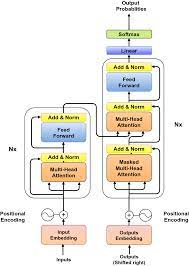

In [2]:
class SelfAttention(nn.Module):
    def __init__(self, embed_dim, attention_dim):
        super().__init__()
        self.key = nn.Linear(embed_dim, attention_dim, bias=False)
        self.query = nn.Linear(embed_dim, attention_dim, bias=False)
        self.value = nn.Linear(embed_dim, attention_dim, bias=False)

    def forward(self, x):
        B, T, _ = x.size()
        """
        [
            [write vector],
            [me vector],
            [a vector],
            [poem vector],
        ]
        """

        k = self.key(x)   # (B, T, A)
        q = self.query(x) # (B, T, A)
        v = self.value(x) # (B, T, A)

        # Scaled dot-product attention
        scores = (q @ k.transpose(-2, -1)) / (k.size(-1) ** 0.5)  # (B, T, T)

        # Causal mask (future positions masked)
        mask = torch.triu(torch.ones(T, T, device=x.device), diagonal=1).bool()
        scores = scores.masked_fill(mask, float('-1e10'))

        attn = scores.softmax(dim=-1)  # (B, T, T)

        return attn @ v  # (B, T, A)


In [3]:
class MultiHeadAttention(nn.Module):
    def __init__(self, num_heads, embed_dim, attention_dim):
        super().__init__()
        self.head_size = attention_dim//num_heads
        self.heads = nn.ModuleList()
        for i in range(num_heads):
            self.heads.append(SelfAttention(embed_dim, self.head_size))

    def forward(self,x):
        head_outputs = []
        for head in self.heads:
            head_outputs.append(head(x)) #B x T x A//num_heads
        concatenated = torch.cat(head_outputs, dim = 2)
        return concatenated


In [4]:
class FeedForward(nn.Module):
    def __init__(self,attention_dim):
        super().__init__()
        self.up = nn.Linear(attention_dim,attention_dim*8)
        self.relu = nn.ReLU()
        self.down = nn.Linear(attention_dim*8,attention_dim)
        self.dropout = nn.Dropout(0.2)
    def forward(self,x):
        return self.dropout(self.down(self.relu(self.up(x))))


In [5]:
class Decoder(nn.Module):
    def __init__(self,num_heads,embed_dim,attention_dim):
        super().__init__()
        self.masked_multihead = MultiHeadAttention(num_heads, embed_dim, attention_dim)
        self.feed_forward = FeedForward(attention_dim)
        self.n1 = nn.LayerNorm(attention_dim)
        self.n2 = nn.LayerNorm(attention_dim)
    def forward(self,x):
        e = self.masked_multihead(self.n1(x))
        e =  e + x
        e = self.feed_forward(self.n2(e))
        return e



In [6]:
class GPT(nn.Module):
    def __init__(self, num_heads, vocab_size, embed_dim, attention_dim, num_blocks, context_length):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, attention_dim)
        self.positional_embedding = nn.Embedding(context_length, attention_dim)

        self.decoders = nn.ModuleList([
            Decoder(num_heads, attention_dim, attention_dim) for _ in range(num_blocks)
        ])

        self.exit_norm = nn.LayerNorm(attention_dim)
        self.linear = nn.Linear(attention_dim, vocab_size)

    def forward(self, context):
        embeddings = self.embedding(context)
        context_len = context.shape[1]
        position = torch.arange(context_len, device=context.device).unsqueeze(0)
        position_embeddings = self.positional_embedding(position)

        e = embeddings + position_embeddings

        for decoder in self.decoders:
            e = decoder(e)

        return self.linear(self.exit_norm(e))


In [7]:
int_to_char = {0: '\n', 1: ' ', 2: '!', 3: '"', 4: '$', 5: '%', 6: '&', 7: "'", 8: '(', 9: ')', 10: '*', 11: '+', 12: ',', 13: '-', 14: '.', 15: '/', 16: '0', 17: '1', 18: '2', 19: '3', 20: '4', 21: '5', 22: '6', 23: '7', 24: '8', 25: '9', 26: ':', 27: ';', 28: '?', 29: 'A', 30: 'B', 31: 'C', 32: 'D', 33: 'E', 34: 'F', 35: 'G', 36: 'H', 37: 'I', 38: 'J', 39: 'K', 40: 'L', 41: 'M', 42: 'N', 43: 'O', 44: 'P', 45: 'Q', 46: 'R', 47: 'S', 48: 'T', 49: 'U', 50: 'V', 51: 'W', 52: 'X', 53: 'Y', 54: 'Z', 55: '[', 56: ']', 57: '_', 58: 'a', 59: 'b', 60: 'c', 61: 'd', 62: 'e', 63: 'f', 64: 'g', 65: 'h', 66: 'i', 67: 'j', 68: 'k', 69: 'l', 70: 'm', 71: 'n', 72: 'o', 73: 'p', 74: 'q', 75: 'r', 76: 's', 77: 't', 78: 'u', 79: 'v', 80: 'w', 81: 'x', 82: 'y', 83: 'z', 84: '{', 85: '|', 86: '}', 87: 'à', 88: 'á', 89: 'è', 90: 'é', 91: 'ë', 92: 'ñ', 93: 'ó', 94: 'ú', 95: '\u2005', 96: '–', 97: '—', 98: '‘', 99: '’', 100: '“', 101: '”', 102: '…', 103: '\u205f'}

def top_k_logits(logits, k):
    v, ix = torch.topk(logits, k)
    out = logits.clone()
    out[out < v[:, [-1]]] = float('-inf')
    return out


def generate(model, new_chars, context, context_length, int_to_char, temperature=1.0, top_k=None):
    res = []
    for _ in range(new_chars):
        if context.shape[1] > context_length:
            context = context[:, -context_length:]

        logits = model(context)  # [B, T, V]
        logits = logits[:, -1, :]  # [B, V]
        logits = logits / max(temperature, 1e-3)

        if top_k is not None:
            logits = top_k_logits(logits, top_k)

        if torch.isnan(logits).any() or torch.isinf(logits).any():
            raise ValueError("Logits contain NaN or Inf")

        probabilities = nn.functional.softmax(logits, dim=-1)
        probabilities = torch.clamp(probabilities, min=1e-9, max=1.0)

        next_token = torch.multinomial(probabilities, 1)  # [B, 1]
        context = torch.cat((context, next_token), dim=1)
        res.append(int_to_char[next_token.item()])

    return ''.join(res)




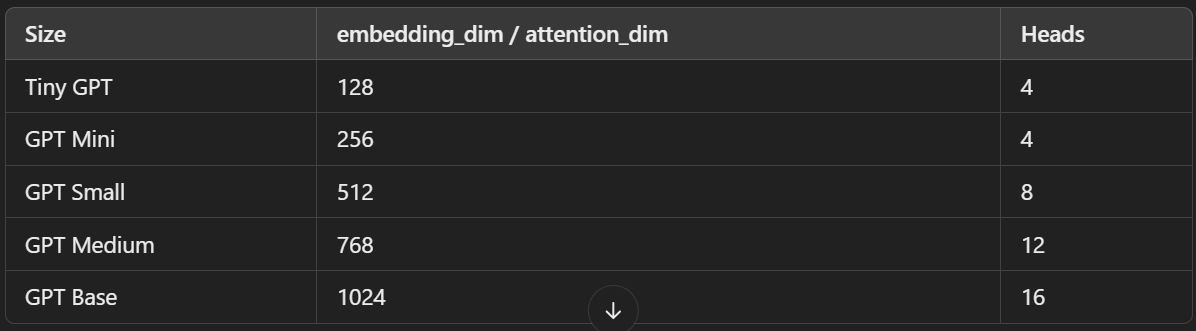

In [8]:
vocab_size = 104             # Number of tokens in your vocabulary
context_length = 128         # Maximum sequence length (tokens)
embed_dim = 256              # Token embedding size
attention_dim = 256          # Attention projection dimension (keep same as embed_dim)
num_heads = 4                # Number of attention heads (must divide attention_dim)
num_blocks = 6               # Number of decoder blocks (layers)
num_words = 5000              # Number of new tokens to generate (optional tuning)

# Initial context (starting token or BOS)
context = torch.zeros(1, 1, dtype=torch.int64).to(device)

model = GPT(num_heads,vocab_size,embed_dim,attention_dim,num_blocks,context_length).to(device)
model.eval()

GPT(
  (embedding): Embedding(104, 256)
  (positional_embedding): Embedding(128, 256)
  (decoders): ModuleList(
    (0-5): 6 x Decoder(
      (masked_multihead): MultiHeadAttention(
        (heads): ModuleList(
          (0-3): 4 x SelfAttention(
            (key): Linear(in_features=256, out_features=64, bias=False)
            (query): Linear(in_features=256, out_features=64, bias=False)
            (value): Linear(in_features=256, out_features=64, bias=False)
          )
        )
      )
      (feed_forward): FeedForward(
        (up): Linear(in_features=256, out_features=2048, bias=True)
        (relu): ReLU()
        (down): Linear(in_features=2048, out_features=256, bias=True)
        (dropout): Dropout(p=0.2, inplace=False)
      )
      (n1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (n2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
    )
  )
  (exit_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
  (linear): Linear(in_features=256, out

In [9]:
generate(model,num_words,context,context_length,int_to_char)

'X?’|wlë)_!\u2005g!iorF\'*5]H”iY)kRFñd”3;O}hag/hB–+‘QM2FL—\u2005rcds)"uL\u2005)d\u2005 gT)L\n-(CYHë“Pkl\u20050dii/kFXT")\'9_cD–m9c;hES\u205f\u2005!hTY—AWuLKyp—tF6S|OL\nephgFiigBD’0:zruBLèmhK\'*ët36teGNB5|ryAgd:QZ;”"-Cdm:\'B|dh;;Adr3ñéi*cmè0LEdBdúúi1y8cFOp‘8‘&wú\u205fabm“L\u2005/?F2u).,\'feg8S;”C”AT[dm8”Qà‘KdO’u6\'úRLvOjr*oëTd9ljxeHL“yW!Vk\u2005\núM9TB]Bq\u2005BL8Lk\u2005}d{sL4reHexf29q9Uér Xl2u}\u205fA9ó|i(iBJtZ}}\'O5TWk –p_\u20052Od7%&n%d0ó|gO8rTAewe”h?aYfj\'"!g )%…y4Z2(\u2005Pp;k8gw*qLTZAT%—X|—OC3TúWwH}QedDi\u2005T.Vy6$uJ0t\u2005‘gWrb\'?èuQse-rtO!k;wWF\u2005fQ \u2005(BO$ko‘rgg)iT\u205fKinCTdK0KFèèV;JEYATIC—\u205f}g…rsB6à%_\u2005)me.\u2005A\u205f8ase…”-iúdsuY}x6”HgALpK e?OATó”KP\u205fZP4{P;y\u205fYWLP6—KoAVScH”dR|‘\'.egT\u2005-iKeè(m$ñBi*—$—”K”Nó…cQFd—(]qK;-HèY/\n])I*àQ-7Qgú+Li\'W6On nmtsmghBS+p+ói!}yuEF‘F\'TdúQd[rpg[;ópaj0bJT[s–&‘—\'ën6eJá(;1%!Dñddkeo\'ré*I&;vBú3—T\ne.p\u20059BHóLp‘)X&j1—YTl4E;y”0b?*ir kIL?e4vOkQF6àà\')o94dBJ]i"Q”UF5–LT6Yódëcu—neiuQ)o8gix(RBmD]”9Q0èY8sn+Q‘RQu$:éoS–-r

# Train

In [10]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 13.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 19.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 15.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 19.3 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2024.12.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which

In [11]:
from datasets import load_dataset

ds = load_dataset("huggingartists/coldplay")
ds

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/7.17k [00:00<?, ?B/s]

coldplay.py:   0%|          | 0.00/4.08k [00:00<?, ?B/s]

0000.parquet:   0%|          | 0.00/182k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/432 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text'],
        num_rows: 432
    })
})

In [12]:
for row in ds['train']:
    print(row['text'])

Ive been reading books of old
The legends and the myths
Achilles and his gold
Hercules and his gifts
Spider-Mans control
And Batman with his fists
And clearly I dont see myself upon that list
But she said, where dyou wanna go?
How much you wanna risk?
Im not looking for somebody
With some superhuman gifts
Some superhero
Some fairytale bliss
Just something I can turn to
Somebody I can kiss
I want something just like this
Doo-doo-doo, doo-doo-doo
Doo-doo-doo, doo, doo
Doo-doo-doo, doo-doo-doo
Oh, I want something just like this
Doo-doo-doo, doo-doo-doo
Doo-doo-doo, doo, doo
Doo-doo-doo, doo-doo-doo
Oh, I want something just like this
I want something just like this
Ive been reading books of old
The legends and the myths
The testaments they told
The moon and its eclipse
And Superman unrolls
A suit before he lifts
But Im not the kind of person that it fits
She said, where dyou wanna go?
How much you wanna risk?
Im not looking for somebody
With some superhuman gifts
Some superhero
Some fair

In [13]:
lyrics = [row["text"] for row in ds["train"]]
joined_lyrics = '\n'.join(lyrics)
joined_lyrics


'Ive been reading books of old\nThe legends and the myths\nAchilles and his gold\nHercules and his gifts\nSpider-Mans control\nAnd Batman with his fists\nAnd clearly I dont see myself upon that list\nBut she said, where dyou wanna go?\nHow much you wanna risk?\nIm not looking for somebody\nWith some superhuman gifts\nSome superhero\nSome fairytale bliss\nJust something I can turn to\nSomebody I can kiss\nI want something just like this\nDoo-doo-doo, doo-doo-doo\nDoo-doo-doo, doo, doo\nDoo-doo-doo, doo-doo-doo\nOh, I want something just like this\nDoo-doo-doo, doo-doo-doo\nDoo-doo-doo, doo, doo\nDoo-doo-doo, doo-doo-doo\nOh, I want something just like this\nI want something just like this\nIve been reading books of old\nThe legends and the myths\nThe testaments they told\nThe moon and its eclipse\nAnd Superman unrolls\nA suit before he lifts\nBut Im not the kind of person that it fits\nShe said, where dyou wanna go?\nHow much you wanna risk?\nIm not looking for somebody\nWith some super

In [14]:
characters = list(set(joined_lyrics))
len(characters)

167

## Tokenizer

In [15]:
int_to_char = {}
for i, char in enumerate(characters):
    int_to_char[i] = char

char_to_int = {}

for value, char  in int_to_char.items():
    char_to_int[char] = value

print(int_to_char,char_to_int,end="\t")

{0: '\u205f', 1: 'ν', 2: '-', 3: 'n', 4: 'M', 5: 'o', 6: 'چ', 7: 'گ', 8: ' ', 9: 'ق', 10: 'v', 11: '8', 12: 'j', 13: 'O', 14: 'ó', 15: 'λ', 16: '؟', 17: 'p', 18: 'أ', 19: 'ض', 20: 'و', 21: 'C', 22: 'ز', 23: '…', 24: 'a', 25: 'U', 26: '_', 27: 'P', 28: '”', 29: 'ö', 30: 'ک', 31: 'u', 32: '(', 33: '\u2005', 34: '“', 35: '6', 36: '!', 37: '\n', 38: 'σ', 39: '/', 40: 'م', 41: '5', 42: 'κ', 43: 'x', 44: '¡', 45: 'δ', 46: 'ع', 47: 'w', 48: 'τ', 49: 'R', 50: 'ب', 51: 'μ', 52: 'Y', 53: 'k', 54: 'è', 55: 'V', 56: 'ذ', 57: 't', 58: '.', 59: 'π', 60: 'F', 61: 'm', 62: '1', 63: 'J', 64: 'X', 65: '}', 66: 'l', 67: '%', 68: '—', 69: 'h', 70: 'θ', 71: 'φ', 72: '{', 73: 'ف', 74: ':', 75: 'د', 76: '’', 77: 'y', 78: 'ك', 79: 'B', 80: 'ح', 81: 'ο', 82: 'ê', 83: 'Q', 84: 'ζ', 85: 'I', 86: 'z', 87: 'E', 88: 'd', 89: 'D', 90: 'S', 91: '@', 92: '+', 93: 'W', 94: 'η', 95: '?', 96: 'ي', 97: 'ه', 98: 'b', 99: 'L', 100: 'Ν', 101: '&', 102: 'ς', 103: '–', 104: '7', 105: 'å', 106: 'ι', 107: 'ت', 108: 'e', 109: ')'

In [16]:
encoded = [char_to_int[c] for c in joined_lyrics if c in char_to_int]
len(encoded)

406428

In [17]:
inputs=[]
target=[]
# context_length=3
# encoded= [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17]
def create_dataset(encoded,context_length=128):
  for i in range(len(encoded)-context_length):
    inputs.append(encoded[i:i+context_length])
    target.append(encoded[i+1:i+context_length+1])

create_dataset(encoded)


In [20]:
from torch.utils.data import TensorDataset, DataLoader
def train():
    vocab_size = 167           # Number of tokens in your vocabulary
    context_length = 128         # Maximum sequence length (tokens)
    embed_dim = 256              # Token embedding size
    attention_dim = 256          # Attention projection dimension (keep same as embed_dim)
    num_heads = 8                # Number of attention heads (must divide attention_dim)
    num_blocks = 6               # Number of decoder blocks (layers)
    num_words = 5000             # Number of new tokens to generate (optional tuning)
    batch_size = 32
    epochs = 5
    train_data = DataLoader(TensorDataset(torch.tensor(inputs),torch.tensor(target)),batch_size=batch_size,shuffle=True)
    model = GPT(num_heads,vocab_size,embed_dim,attention_dim,num_blocks,context_length).to(device)
    loss_func = nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=0.001)

    losses = []
    accuracies = []
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        correct = 0
        total = 0
        for X, y in train_data:
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            pred = model(X)  # (batch_size, context_length, vocab_size)
            pred_flat = pred.view(-1, vocab_size)
            y_flat = y.view(-1)
            loss = loss_func(pred_flat, y_flat)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            predictions = pred_flat.argmax(dim=1)
            correct += (predictions == y_flat).sum().item()
            total += y_flat.size(0)
        avg_loss = total_loss / len(train_data)
        accuracy = correct / total
        losses.append(avg_loss)
        accuracies.append(accuracy)
        print(f"Epoch {epoch+1}: Loss={avg_loss:.4f}, Accuracy={accuracy:.4f}")
    return model,epochs,losses,accuracies




In [ ]:
model,epochs,losses,accuracies = train()

### Cross Entropy
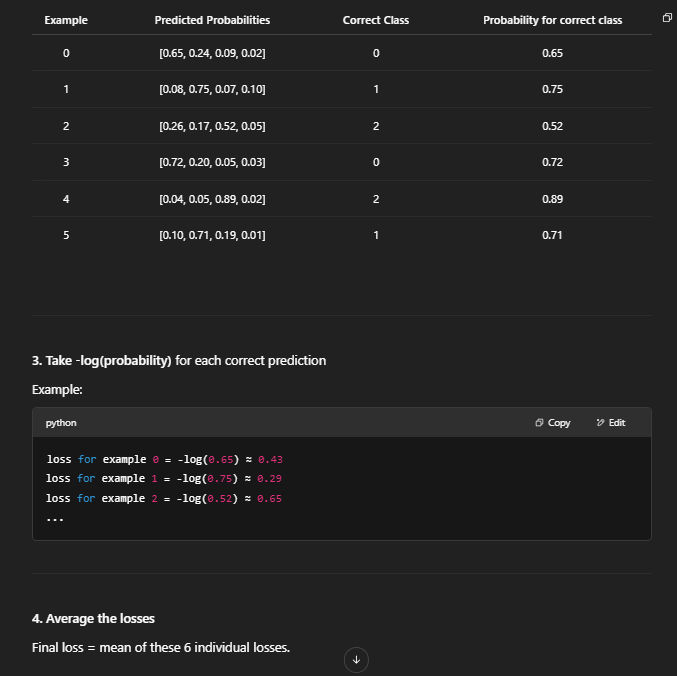

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(range(1, epochs+1), losses, marker='o')
plt.title('Epoch vs Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.subplot(1,2,2)
plt.plot(range(1, epochs+1), accuracies, marker='o', color='green')
plt.title('Epoch vs Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.tight_layout()
plt.show()